# HDF5 read and pre-process from differential phase to phase

In [64]:
# Import libraries
import numpy as np
import h5py
import scipy.signal as signal
import matplotlib.pyplot as plt

In [65]:
# Set filename and read in metadata
file_name = "Melody P1.hdf5"

# Index range for output
from_index = 0
to_index = 10000

# Curves count for output
curves_output_count = 20

# Read the differential phase file and metadata
with h5py.File(file_name, 'r', libver='latest') as h5_file:
    data_dphase = h5_file.get('DAS')[from_index:to_index,:curves_output_count]
    start_time = h5_file['Metadata/Timestamp'][0]
    pulse_rate = h5_file['DAQ/RepetitionFrequency'][0]
    start_distance = h5_file['DAQ/PositionStart'][0]
    end_distance = h5_file['DAQ/PositionEnd'][0]
    
# integrate the differential phase to return phase then convert to radians
data_phase = np.cumsum(data_dphase, axis=0) * (np.pi / 2 ** 15)
# Example 4 Hz highpass filter
cutoff = 4 # Filter cut-off in Hz
nyq = pulse_rate / 2 # Nyquist Frequency
b, a = signal.butter(5, cutoff / nyq, btype='high', analog=False)
data_highpass_phase = signal.filtfilt(b, a, data_phase)

# Generate distance array
dist = np.arange(start_distance, end_distance, (end_distance-start_distance)/data_highpass_phase.shape[0])

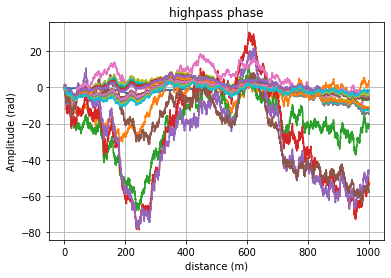

In [66]:
# Creating plot
fig, ax = plt.subplots()

# Plot data
ax.plot(dist[from_index:to_index], data_highpass_phase[from_index:to_index,:curves_output_count])
ax.set(xlabel='distance (m)', ylabel='Amplitude (rad)',
       title='highpass phase')
ax.grid()
plt.show()

In [67]:
# Prepare data to save to file
data_highpass_phase_n_dist=np.zeros((data_highpass_phase.shape[0],data_highpass_phase.shape[1]+1))

data_highpass_phase_n_dist[:,1:] = data_highpass_phase
data_highpass_phase_n_dist[:,0] = dist

In [68]:
# Save to txt
np.savetxt("DAS.txt", data_highpass_phase_n_dist[from_index:to_index,:curves_output_count], fmt='%-7.2f')

# The End